In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import os

In [2]:
###### taken from https://gitlab.com/edward_chen/joint_segmentation_motion_estimation/-/blob/master/camus_notebooks/test_stanford_dynamic_with_echonet_trained_clas.ipynb
def bland_altman_plot_TwoPop(data1, data2, baseline_BA_limit=None, linewidth=2.5, *args, **kwargs):
    
    if 'c' in kwargs:
        # Pandas, amazing!
        colorSeries = pd.Series([tuple(row) for row in kwargs['c']])
        colorCounts = colorSeries.value_counts()
        # returns the color counts in descending order.
        pop1c, pop2c = colorCounts.index[0], colorCounts.index[1]
        print('TwoPop: found colors {}({}) and {}({})'.\
             format(pop1c, colorCounts[0], pop2c, colorCounts[1]))

        pop1i = colorSeries[colorSeries == pop1c].index.values
        pop2i = colorSeries[colorSeries == pop2c].index.values
        
    
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.nanmean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    print('Dims data1 {}, diff {}'.format(data1.shape, diff.shape))
    
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md, linestyle='-')
    
    axes = plt.gca()
    x_lim = axes.get_xlim()
    x_range = x_lim[1] - x_lim[0]
    
    plt.annotate("", xy=(x_lim[0] + 0.40 * x_range, md + np.percentile(abs(diff), 50)), xytext=(x_lim[0] + 0.40 * x_range, md - np.percentile(abs(diff), 50)),
                 arrowprops=dict(arrowstyle='|-|', color='darkorange', linestyle='-', mutation_scale =3.2, linewidth=linewidth))
    plt.annotate("", xy=(x_lim[1] - 0.40 * x_range, md + np.percentile(abs(diff), 50)), xytext=(x_lim[1] - 0.40 * x_range, md - np.percentile(abs(diff), 50)),
                 arrowprops=dict(arrowstyle='|-|', color='darkorange', linestyle='-', mutation_scale =3.2, linewidth=linewidth))
    
    plt.annotate("", xy=(x_lim[0] + 0.25 * x_range, md + np.percentile(abs(diff), 75)), xytext=(x_lim[0] + 0.25 * x_range, md - np.percentile(abs(diff), 75)),
                 arrowprops=dict(arrowstyle='|-|', color='red', linestyle='-', mutation_scale =4.2, linewidth=linewidth))
    plt.annotate("", xy=(x_lim[1] - 0.25 * x_range, md + np.percentile(abs(diff), 75)), xytext=(x_lim[1] - 0.25 * x_range, md - np.percentile(abs(diff), 75)),
                 arrowprops=dict(arrowstyle='|-|', color='red', linestyle='-', mutation_scale =4.2, linewidth=linewidth))
    
    plt.annotate("", xy=(x_lim[0] + 0.10 * x_range, md + 1.96 * sd), xytext=(x_lim[0] + 0.10 * x_range, md - 1.96 * sd),
                 arrowprops=dict(arrowstyle='|-|', color='blue', linestyle='-', mutation_scale =5.2, linewidth=linewidth))
    plt.annotate("", xy=(x_lim[1] - 0.10 * x_range, md + 1.96 * sd), xytext=(x_lim[1] - 0.10 * x_range, md - 1.96 * sd),
                 arrowprops=dict(arrowstyle='|-|', color='blue', linestyle='-', mutation_scale =5.2, linewidth=linewidth))
    
    #plt.axhline(md + 1.96 * sd, color='blue', linestyle='dashed', label='1.96 std ({:.2f})'.format(1.96 * sd))
    plt.text(max(mean) - 28, md  + 1, '{:.1f}'.format(md), horizontalalignment='right')
    plt.text(max(mean) + 1, md + 1.96*sd +1, '{:.1f}'.format(md + 1.96*sd), horizontalalignment='right')
    
    #plt.axhline(md - 1.96 * sd, color='blue', linestyle='dashed')
    plt.ylim(top=max(diff) + 15)
    
    if baseline_BA_limit != None:
        plt.axhline(md + baseline_BA_limit, color='black', linestyle='dotted', alpha=1.0)
        plt.axhline(md - baseline_BA_limit, color='black', linestyle='dotted', alpha=1.0)
        
    
    plt.text(max(mean) + 1, md - 1.96*sd - 6, '{:.1f}'.format(md - 1.96*sd), horizontalalignment='right')
    
    arrow_50 = mlines.Line2D([], [], color='darkorange', linestyle='-', label='50 % ({:.1f})'.format(np.percentile(abs(diff), 50)))
    arrow_75 = mlines.Line2D([], [], color='red', linestyle='-', label='75 % ({:.1f})'.format(np.percentile(abs(diff), 75)))
    arrow_std = mlines.Line2D([], [], color='blue', linestyle='-', label='1.96 std ({:.1f})'.format(1.96 * sd))
    
    plt.legend(handles=[arrow_50, arrow_75, arrow_std], loc='upper left', prop={'size': 18}, frameon=False)

    print('Bias {:.4f}, med bias {:.4f}, BA limits +- {:.4f} ({:.4f})'.format(md, np.median(diff), 1.96*sd, sd))
    print('50, 75, 95 abs error percentile:\n {:.4f}  {:.4f}  {:.4f}'.format(np.percentile(abs(diff), 50), np.percentile(abs(diff), 75),
                                                                             np.percentile(abs(diff), 95)))



def vis_linear_and_BA_plots(dataclinical, dataauto, strtitle, figsize=None,
                            linewidth=2.5,
                            datalabels = ['Clinical', 'Auto'], 
                            scatterarg={}, 
                            base_filename = None,
                            baseline_BA_limit=None):
    '''
    I wish a docstring was here to let me know what datatype the parameters are.
    I am left to guess that they are some kind of numpy manipulatable entity with unknown shape.
    
    '''

    x = np.asarray([dataclinical, dataauto]).transpose()

    dnum = len(x[:,0])
    print('# of data : ', len(x[:,0]))
    lr = linregress(x[:,0],x[:,1])

    #ax.plot(x, fit[0] * x + fit[1], color='red')
    #ax.scatter(x, y)

#     plt.figure(figsize=(7, 7))
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(7, 7))
    #plt.subplot(211)
    plt.scatter(x[:,0], x[:,1], **scatterarg)
    plt.text(dataclinical.min(), dataauto.max() - 10, '{:d} patients\nr = {:.2f} '.format(dnum, lr[2]), fontsize=13, c='darkblue')
    plt.plot(x[:,0], lr[0] * x[:,0] + lr[1], color='red')
    plt.xlabel(datalabels[0])
    plt.ylabel(datalabels[1])
    #plt.title('{:8d} patients\nr = {:.3f} '.format(dnum, lr[2]))
    plt.axis('equal')
    plt.axis('square')
    plt.show()
    
    if base_filename:
        # User's responsibility to set the style before getting here.
        # Save the plot, use the provided filename.
        plt.savefig(base_filename+'_LN.pdf', bbox_inches='tight')
        
        plt.savefig(base_filename+'_LN.png', bbox_inches='tight',
                    dpi=200, transparent=False);

        plt.savefig(base_filename+'_LN_transp.png', bbox_inches='tight',
                    dpi=200, transparent=True);


#     plt.figure(figsize=(6,4))
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(8, 6))
    #plt.subplot(212)
    
    #plt.yticks(np.arange(-30, 45, 10))
    #plt.ylim(-35, 49)
    
#     bland_altman_plot_TwoPop(x[:,0], x[:,1], linewidth=linewidth, baseline_BA_limit=baseline_BA_limit, **scatterarg)
#     plt.title(strtitle, fontsize=22) # +' - Bland-Altman Plot (#{})'.format(dnum))

#     plt.ylabel(datalabels[0] + ' - ' + datalabels[1])
#     plt.xlabel('Mean of ('+datalabels[0] + ', ' + datalabels[1] + ')')
#     plt.show()
    
#     if base_filename:
#         # User's responsibility to set the style before getting here.
#         # Save the plot, use the provided filename.
#         plt.savefig(base_filename+'_BA.pdf', bbox_inches='tight')
        
#         plt.savefig(base_filename+'_BA.png', bbox_inches='tight',
#                     dpi=200, transparent=False);

#         plt.savefig(base_filename+'_BA_transp.png', bbox_inches='tight',
#                     dpi=200, transparent=True);

In [3]:
name = 'Original_Pretrained_R2plus1DMotionSegNet.pthlog.csv'

data = pd.read_csv(f'./csvs/previous_saves/{name}')

pred_ef = 'Predicted EF'
true_ef = 'True EF'

In [4]:
# import matplotlib
# from scipy.stats import linregress
# from matplotlib.patches import mlines

# # 50,  75,  95 percentile of abs errors
# mean = np.nanmean(np.array([data[pred_ef].mean(), data[true_ef].mean()]))
# diff = data[pred_ef] - data[true_ef]

# font = {'family' : 'DejaVu Sans',
#         'weight' : '20',
#         'size'   : 19}

# matplotlib.rc('font', **font)


# op_colors = np.zeros(shape=(diff.shape[0], 4))
# op_colors[:, 2] = 0.8
# op_colors[:, 1] = 0.4
# normalized_opacities = (abs(diff) - abs(diff).min())
# normalized_opacities = normalized_opacities / normalized_opacities.max()
# normalized_opacities = (1 - np.sqrt(np.log2(normalized_opacities + 1)))
# #normalized_opacities = 1 - normalized_opacities
# op_colors[:, 3] = normalized_opacities * 0.75

# args = {'color':op_colors}

# vis_linear_and_BA_plots(data[true_ef], data[pred_ef], 
#                         strtitle="(EchoNet-Dynamic)\nEjection Fraction", scatterarg=args,baseline_BA_limit=15.1)

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# https://stackoverflow.com/questions/16399279/bland-altman-plot-in-python
def bland_altman_plot(data1, data2, *args, **kwargs):
    '''
    data1 and data2 are numpy like arrays, pandas dataframe will work
    '''
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.nanmean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.nanmean(diff)                   # Mean of the difference
    sd        = np.nanstd(diff, axis=0)            # Standard deviation of the difference

    print(f'mean of diff: {md}')
    
    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title('Bland-Altman Plot')
    plt.show()

/opt/anaconda3/envs/dynamic37-wang/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


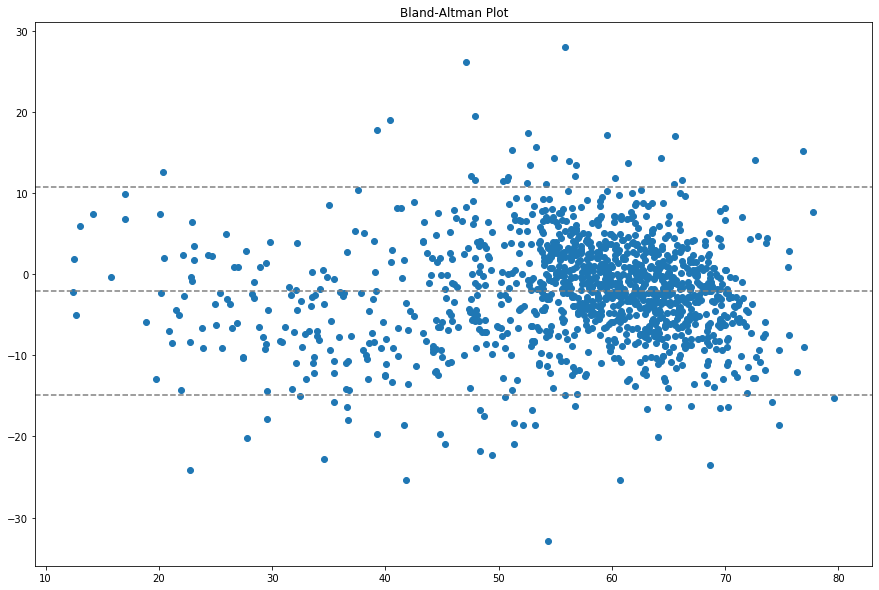

mean of diff: -2.093933030370751


In [31]:
from numpy.random import random

bland_altman_plot(data[true_ef], data[pred_ef])

In [32]:
# why are there nan values?

# we might as well look at the outliers

from scipy.stats import linregress
thing = linregress(data[true_ef], data[pred_ef])
thing

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [33]:
data.describe()

,Predicted EF,True EF,Predicted GLS,True GLS,ED Dice,ES Dice
count,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000
mean,57.626467,55.532534,-0.154381,-0.154627,0.935451,0.907362
std,11.907741,12.193880,0.054816,0.129138,0.032408,0.051521
min,10.039696,10.192957,-0.293233,-0.783599,0.553846,0.447328
25%,52.473297,51.388474,-0.191860,-0.191781,0.922575,0.888344
50%,59.663097,58.749950,-0.160000,-0.164384,0.942135,0.918878
75%,65.678328,63.551777,-0.122905,-0.131783,0.956739,0.941176
max,87.289323,84.452354,0.155405,2.299213,0.983438,0.975815


In [51]:
patients_with_low_dice = data.query("`ED Dice` < 0.80 or `ES Dice` < 0.80")

In [52]:
patients_with_low_dice.describe()

,Predicted EF,True EF,Predicted GLS,True GLS,ED Dice,ES Dice
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,61.824284,63.313887,-0.113410,-0.082672,0.867863,0.744783
std,10.800083,9.251774,0.091221,0.529452,0.075443,0.095905
min,30.347434,27.628849,-0.266667,-0.783599,0.553846,0.447328
25%,56.037408,58.507111,-0.176432,-0.201766,0.842654,0.714873
50%,64.115032,64.109463,-0.120393,-0.169649,0.891637,0.757112
75%,67.856252,68.102242,-0.088124,-0.140789,0.912758,0.789158
max,84.047630,84.452354,0.155405,2.299213,0.961213,0.945489


In [53]:
patients_with_low_dice.columns

Index(['Video Index', 'Predicted EF', 'True EF', 'Predicted GLS', 'True GLS',
       'ED Dice', 'ES Dice'],
      dtype='object')

In [56]:
np.array(patients_with_low_dice['Video Index'])

array(['5', '70', '77', '86', '105', '111', '128', '152', '156', '194',
       '222', '230', '258', '264', '298', '314', '324', '338', '351',
       '363', '380', '446', '490', '496', '499', '510', '522', '584',
       '587', '592', '601', '616', '686', '689', '742', '752', '771',
       '773', '877', '900', '908', '913', '932', '992', '998', '1005',
       '1027', '1047', '1268', '1271'], dtype=object)